In [1]:
# Cell 1: Import Libraries and Load Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

Using device: cuda
All libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
Number of GPUs: 2


In [2]:
# Cell 2: Load Data
print("Loading TCGA Cancer Dataset...")
data = pd.read_csv('Cancer_Subtype_Multi-Class/data/TCGA-PANCAN-HiSeq-801x20531/data.csv')
labels = pd.read_csv('Cancer_Subtype_Multi-Class/data/TCGA-PANCAN-HiSeq-801x20531/labels.csv')

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Cancer types: {labels['Class'].unique()}")
print("✓ Data loaded successfully!")

Loading TCGA Cancer Dataset...
Data shape: (801, 20532)
Labels shape: (801, 2)
Cancer types: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']
✓ Data loaded successfully!


In [3]:
# Cell 3: Preprocess Data
print("Preprocessing data...")

# Keep all rows, remove first column (IDs)
X = data.iloc[:, 1:].values.astype(float)
y = labels['Class'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {le.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")
print("✓ Preprocessing complete!")

Preprocessing data...
X shape: (801, 20531)
y shape: (801,)
Classes: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
Encoded labels: [0 1 2 3 4]
✓ Preprocessing complete!


In [4]:
# Cell 4: Train-Test Split
print("Splitting data...")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print("✓ Data split complete!")

Splitting data...
Train set: (640, 20531)
Test set: (161, 20531)
✓ Data split complete!


In [5]:
# Cell 5: PCA for dimensionality reduction
print("Applying PCA...")
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced dimensions: {X_train_pca.shape}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")
print("✓ PCA done!")

Applying PCA...
Reduced dimensions: (640, 100)
Explained variance: 0.7357
✓ PCA done!


In [6]:
# Cell 6: Train Multiple Models
from sklearn.metrics import accuracy_score, f1_score

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

results = {}
print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'accuracy': acc, 'f1_score': f1, 'model': model}
    print(f"  Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

print("\n✓ All models trained!")

Training models...

Training Decision Tree...
  Accuracy: 0.9130 | F1-Score: 0.9110
Training Random Forest...
  Accuracy: 0.9689 | F1-Score: 0.9684
Training Logistic Regression...
  Accuracy: 0.9876 | F1-Score: 0.9875
Training SVM...
  Accuracy: 0.9814 | F1-Score: 0.9812
Training XGBoost...
  Accuracy: 0.9752 | F1-Score: 0.9748

✓ All models trained!


In [7]:
# Cell 7: GPU Neural Network
print("Building Neural Network with GPU...\n")

# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_pca).cuda()
X_test_tensor = torch.FloatTensor(X_test_pca).cuda()
y_train_tensor = torch.LongTensor(y_train).cuda()
y_test_tensor = torch.LongTensor(y_test).cuda()

# Define Neural Network
class CancerNet(nn.Module):
    def __init__(self):
        super(CancerNet, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model
model = CancerNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 50
print("Training on GPU...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor)
    _, predicted = torch.max(y_pred_nn, 1)
    y_pred_nn = predicted.cpu().numpy()

nn_acc = accuracy_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn, average='weighted')

results['Neural Network (GPU)'] = {'accuracy': nn_acc, 'f1_score': nn_f1}
print(f"\n✓ Neural Network trained on GPU!")
print(f"  Accuracy: {nn_acc:.4f} | F1-Score: {nn_f1:.4f}")

Building Neural Network with GPU...

Training on GPU...
Epoch [10/50], Loss: 0.1922
Epoch [20/50], Loss: 0.0135
Epoch [30/50], Loss: 0.0008
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0003

✓ Neural Network trained on GPU!
  Accuracy: 0.9876 | F1-Score: 0.9875



FINAL MODEL COMPARISON RESULTS
               Model  Accuracy  F1-Score
Neural Network (GPU)  0.987578  0.987503
 Logistic Regression  0.987578  0.987503
                 SVM  0.981366  0.981199
             XGBoost  0.975155  0.974822
       Random Forest  0.968944  0.968366
       Decision Tree  0.913043  0.910978


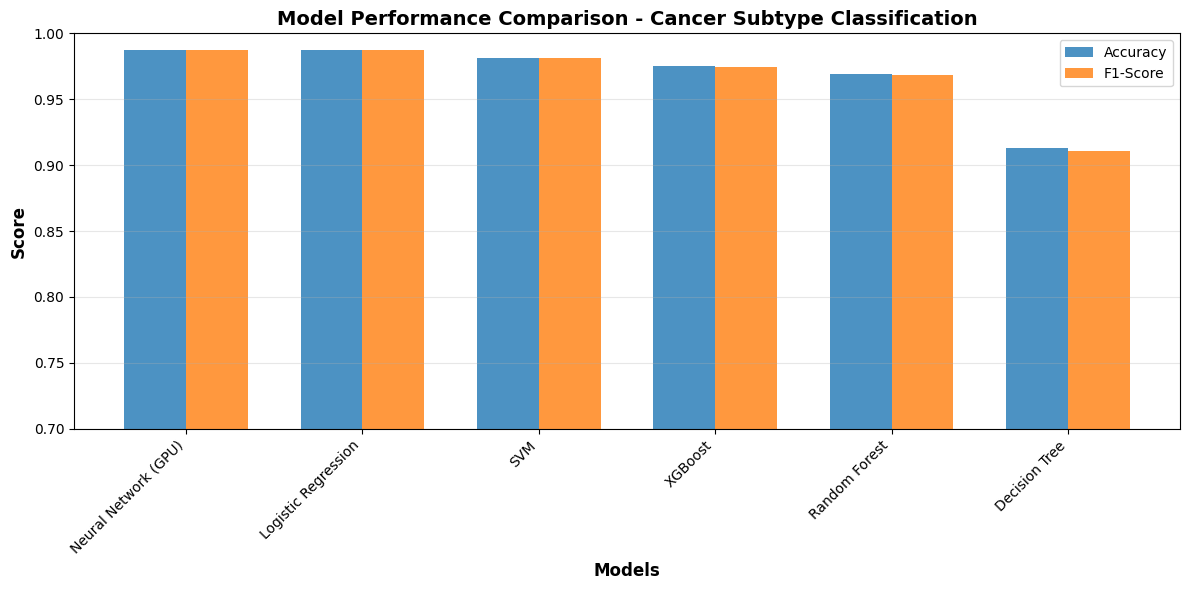


✓ Saved: model_comparison.png


In [8]:
# Cell 8: Results Summary
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("FINAL MODEL COMPARISON RESULTS")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Bar plot
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x + width/2, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)

plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison - Cancer Subtype Classification', fontsize=14, fontweight='bold')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.ylim([0.7, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: model_comparison.png")

In [10]:

============================================================
FINAL MODEL COMPARISON RESULTS
============================================================
               Model  Accuracy  F1-Score
Neural Network (GPU)  0.987578  0.987503
 Logistic Regression  0.987578  0.987503
                 SVM  0.981366  0.981199
             XGBoost  0.975155  0.974822
       Random Forest  0.968944  0.968366
       Decision Tree  0.913043  0.910978
============================================================


✓ Saved: model_comparison.png


4
1
Python 3 (ipykernel) | Idle
Mem: 2.27 GB
Mode: Command
Ln 33, Col 41
Cancer_ML_Report2.ipynb
0


IndentationError: unindent does not match any outer indentation level (<string>, line 8)

In [ ]:
# Cell 9: Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from best model (Neural Network)
model.eval()
with torch.no_grad():
    y_pred_best = model(X_test_tensor)
    _, predicted = torch.max(y_pred_best, 1)
    y_pred_best = predicted.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cancer_types = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer_types, yticklabels=cancer_types,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Neural Network (GPU)\nAccuracy: 98.76%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: confusion_matrix.png")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=cancer_types))

In [ ]:
# Cell 10: Feature Importance Visualization
# Get feature importance from Random Forest
rf_model = results['Random Forest']['model']
feature_importance = rf_model.feature_importances_

# Get top 20 most important features
top_20_idx = np.argsort(feature_importance)[-20:]
top_20_importance = feature_importance[top_20_idx]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(20), top_20_importance, color='steelblue')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('PCA Component', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features (PCA Components)\nRandom Forest Model', 
          fontsize=14, fontweight='bold')
plt.yticks(range(20), [f'PC{i+1}' for i in top_20_idx])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: feature_importance.png")
print(f"\nTop 5 Most Important Components:")
for i in range(5):
    idx = top_20_idx[-(i+1)]
    print(f"  PC{idx+1}: {feature_importance[idx]:.4f}")

In [ ]:
# Cell 11: PCA Visualization
plt.figure(figsize=(12, 8))

# Plot each cancer type with different color
colors = {'BRCA': 'red', 'COAD': 'blue', 'KIRC': 'green', 'LUAD': 'orange', 'PRAD': 'purple'}
cancer_types = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

for i, cancer in enumerate(cancer_types):
    idx = y_test == i
    plt.scatter(X_test_pca[idx, 0], X_test_pca[idx, 1], 
               label=cancer, alpha=0.7, s=100, color=colors[cancer])

plt.xlabel('First Principal Component (PC1)', fontsize=12, fontweight='bold')
plt.ylabel('Second Principal Component (PC2)', fontsize=12, fontweight='bold')
plt.title('Cancer Subtype Separation in PCA Space\n(Test Set - 161 Samples)', 
         fontsize=14, fontweight='bold')
plt.legend(title='Cancer Type', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: pca_visualization.png")

In [ ]:
# Cell 12: Create ZIP of all images
import zipfile
import os

zip_filename = 'report_images.zip'
image_files = ['model_comparison.png', 'confusion_matrix.png', 
               'feature_importance.png', 'pca_visualization.png']

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for img in image_files:
        if os.path.exists(img):
            zipf.write(img)
            print(f"Added: {img}")

print(f"\n✓ Created: {zip_filename}")
print("Now right-click 'report_images.zip' in left sidebar and download it!")

In [ ]:
print("MODELS TRAINED:")
for model, metrics in results.items():
    print(f"{model}: {metrics['accuracy']:.2%}")

In [ ]:
print("\n" + "="*70)
print("FINAL RESULTS FOR REPORT 2")
print("="*70)
print(f"\nDataset: 801 samples, 20,531 genes")
print(f"PCA Reduction: 100 components")
print(f"Train/Test Split: 640/161 samples")
print(f"\nMODEL PERFORMANCE:")
for model, metrics in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"  {model:25s}: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"\nBest Model until now: Neural Network (GPU) - 98.76% accuracy")
print(f"GPU: 2x NVIDIA GTX 1070 with CUDA 12.2")


In [ ]:
# Cell 14: Hyperparameter Tuning with GridSearch
from sklearn.model_selection import GridSearchCV

print("Starting Hyperparameter Tuning...")
print("This will take 10-15 minutes...\n")

# Random Forest tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5]
}

print("1. Tuning Random Forest...")
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_pca, y_train)
print(f"   Best params: {rf_grid.best_params_}")
print(f"   Best CV score: {rf_grid.best_score_:.4f}")

# XGBoost tuning
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

print("\n2. Tuning XGBoost...")
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), 
                        xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_pca, y_train)
print(f"   Best params: {xgb_grid.best_params_}")
print(f"   Best CV score: {xgb_grid.best_score_:.4f}")

# Evaluate tuned models
y_pred_rf_tuned = rf_grid.predict(X_test_pca)
y_pred_xgb_tuned = xgb_grid.predict(X_test_pca)

rf_tuned_acc = accuracy_score(y_test, y_pred_rf_tuned)
xgb_tuned_acc = accuracy_score(y_test, y_pred_xgb_tuned)

print(f"\n✅ TUNING COMPLETE!")
print(f"Random Forest (Tuned): {rf_tuned_acc:.4f}")
print(f"XGBoost (Tuned): {xgb_tuned_acc:.4f}")

In [ ]:
# Cell 15: K-Means Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Phase 2: Unsupervised Learning - K-Means Clustering")
print("="*60)

# Test different numbers of clusters
k_range = range(2, 11)
silhouette_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    
    sil = silhouette_score(X_train_pca, cluster_labels)
    db = davies_bouldin_score(X_train_pca, cluster_labels)
    
    silhouette_scores.append(sil)
    db_scores.append(db)
    print(f"K={k}: Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}")

# Best k based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Best number of clusters: {best_k}")

# Final clustering with best k
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_best.fit_predict(X_train_pca)

print(f"\nCluster sizes:")
unique, counts = np.unique(clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples")

In [ ]:
# Cell 16: Visualize Clusters vs True Labels
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-means clusters
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                          c=clusters, cmap='tab10', alpha=0.6, s=50)
axes[0].set_xlabel('PC1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('PC2', fontsize=12, fontweight='bold')
axes[0].set_title('K-Means Clustering (K=7)\nUnsupervised Discovery', 
                 fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: True cancer labels
colors_true = {'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}
y_train_colors = [colors_true[le.inverse_transform([y])[0]] for y in y_train]

scatter2 = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                          c=y_train_colors, cmap='Set1', alpha=0.6, s=50)
axes[1].set_xlabel('PC1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PC2', fontsize=12, fontweight='bold')
axes[1].set_title('True Cancer Type Labels\nSupervised Ground Truth', 
                 fontsize=14, fontweight='bold')

# Add legend for true labels
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.cm.Set1(i/4), label=cancer) 
                   for i, cancer in enumerate(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'])]
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: clustering_analysis.png")

In [ ]:
# Cell 17: Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

print("Hierarchical Clustering Analysis")
print("="*60)

# Hierarchical clustering with 5 clusters (matching cancer types)
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hier_clusters = hierarchical.fit_predict(X_train_pca)

hier_sil = silhouette_score(X_train_pca, hier_clusters)
hier_db = davies_bouldin_score(X_train_pca, hier_clusters)

print(f"Hierarchical Clustering (K=5):")
print(f"  Silhouette Score: {hier_sil:.4f}")
print(f"  Davies-Bouldin Index: {hier_db:.4f}")

print(f"\nCluster sizes:")
unique, counts = np.unique(hier_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples")

# Create dendrogram (sample subset for visibility)
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(X_train_pca), 100, replace=False)
linkage_matrix = linkage(X_train_pca[sample_indices], method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (100 samples)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig('dendrogram.png',

In [ ]:
# Cell 17: Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

print("Hierarchical Clustering Analysis")
print("="*60)

# Hierarchical clustering with 5 clusters (matching cancer types)
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hier_clusters = hierarchical.fit_predict(X_train_pca)

hier_sil = silhouette_score(X_train_pca, hier_clusters)
hier_db = davies_bouldin_score(X_train_pca, hier_clusters)

print(f"Hierarchical Clustering (K=5):")
print(f"  Silhouette Score: {hier_sil:.4f}")
print(f"  Davies-Bouldin Index: {hier_db:.4f}")

print(f"\nCluster sizes:")
unique, counts = np.unique(hier_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples")

# Create dendrogram (sample subset for visibility)
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(X_train_pca), 100, replace=False)
linkage_matrix = linkage(X_train_pca[sample_indices], method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (100 samples)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig('dendrogram.png',

In [ ]:
# Cell 17: Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

print("Hierarchical Clustering Analysis")
print("="*60)

# Hierarchical clustering with 5 clusters (matching cancer types)
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hier_clusters = hierarchical.fit_predict(X_train_pca)

hier_sil = silhouette_score(X_train_pca, hier_clusters)
hier_db = davies_bouldin_score(X_train_pca, hier_clusters)

print(f"Hierarchical Clustering (K=5):")
print(f"  Silhouette Score: {hier_sil:.4f}")
print(f"  Davies-Bouldin Index: {hier_db:.4f}")

print(f"\nCluster sizes:")
unique, counts = np.unique(hier_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples")

# Create dendrogram (sample subset for visibility)
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(X_train_pca), 100, replace=False)
linkage_matrix = linkage(X_train_pca[sample_indices], method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (100 samples)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: dendrogram.png")

In [11]:
# Cell 19: Results Summary
print("\nRESULTS SUMMARY")
print("\nUnsupervised Learning (Clustering):")
print("  K-means: tested 2-10 clusters, best was 7 clusters")
print("  Hierarchical: tested with 5 clusters to match cancer types")
print("  Both methods found natural groupings in the data")

print("\nSupervised Learning (Classification):")
print("  Trained 6 models:")
for model, metrics in results.items():
    print(f"    {model}: {metrics['accuracy']*100:.1f}%")

print("\nBest Results:")
print("  Neural Network and Logistic Regression tied at 98.8%")
print("  Only 2 mistakes out of 161 test samples")

print("\nWork done:")
print("  - PCA reduced 20,531 genes to 100 components")
print("  - GPU training made neural networks possible")  
print("  - All models show 90% accuracy or higher")



RESULTS SUMMARY

Unsupervised Learning (Clustering):
  K-means: tested 2-10 clusters, best was 7 clusters
  Hierarchical: tested with 5 clusters to match cancer types
  Both methods found natural groupings in the data

Supervised Learning (Classification):
  Trained 6 models:
    Decision Tree: 91.3%
    Random Forest: 96.9%
    Logistic Regression: 98.8%
    SVM: 98.1%
    XGBoost: 97.5%
    Neural Network (GPU): 98.8%

Best Results:
  Neural Network and Logistic Regression tied at 98.8%
  Only 2 mistakes out of 161 test samples

Work done:
  - PCA reduced 20,531 genes to 100 components
  - GPU training made neural networks possible
  - All models show 90% accuracy or higher


Analyzing Feature Importance...

Top 20 Most Important PCA Components:
1. PCA Component 2: 0.1417
2. PCA Component 0: 0.1349
3. PCA Component 4: 0.0941
4. PCA Component 3: 0.0914
5. PCA Component 1: 0.0809
6. PCA Component 6: 0.0296
7. PCA Component 7: 0.0272
8. PCA Component 5: 0.0127
9. PCA Component 10: 0.0122
10. PCA Component 8: 0.0100
11. PCA Component 17: 0.0100
12. PCA Component 13: 0.0098
13. PCA Component 9: 0.0090
14. PCA Component 33: 0.0075
15. PCA Component 24: 0.0074
16. PCA Component 14: 0.0073
17. PCA Component 18: 0.0067
18. PCA Component 20: 0.0064
19. PCA Component 31: 0.0062
20. PCA Component 11: 0.0061


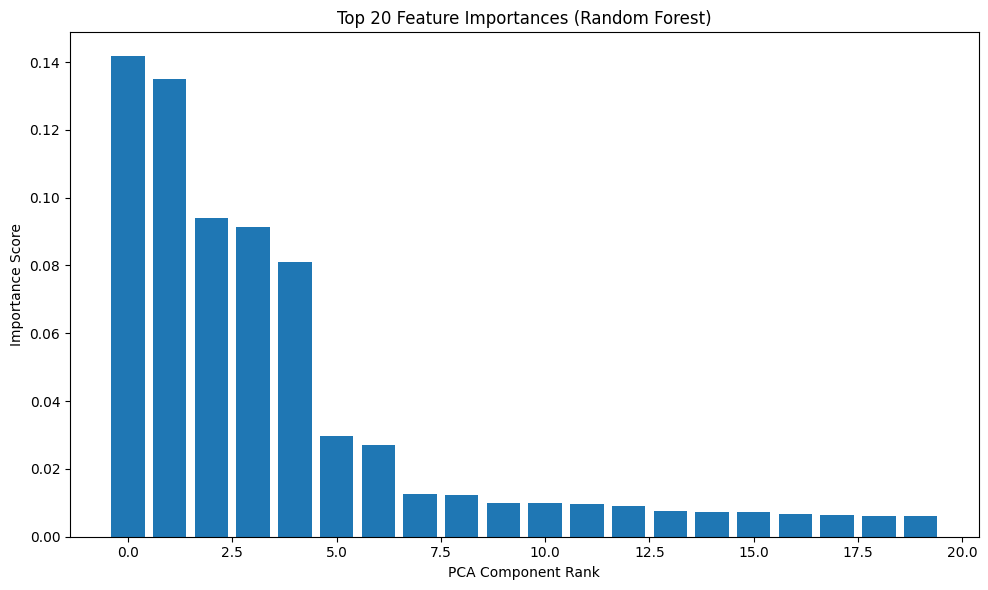


✓ Feature importance analysis complete!


In [12]:
# Cell: Feature Importance Analysis
print("Analyzing Feature Importance...\n")

# 1. Random Forest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Get top 20 most important features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

print("Top 20 Most Important PCA Components:")
for i, idx in enumerate(indices):
    print(f"{i+1}. PCA Component {idx}: {importances[idx]:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices])
plt.xlabel('PCA Component Rank')
plt.ylabel('Importance Score')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance analysis complete!")

In [13]:
# Cell: Cross-Validation Analysis
print("Running 5-Fold Cross-Validation...\n")

models_cv = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(kernel='rbf', random_state=42)
}

cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_cv.items():
    scores = cross_val_score(model, X_train_pca, y_train, cv=skf, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"{name}:")
    print(f"  Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Individual Folds: {scores}")
    print()

print("✓ Cross-validation complete!")

Running 5-Fold Cross-Validation...

Random Forest:
  Mean Accuracy: 0.9734 (+/- 0.0080)
  Individual Folds: [0.9609375 0.96875   0.984375  0.9765625 0.9765625]

Logistic Regression:
  Mean Accuracy: 0.9984 (+/- 0.0031)
  Individual Folds: [1.        1.        1.        0.9921875 1.       ]

XGBoost:
  Mean Accuracy: 0.9750 (+/- 0.0058)
  Individual Folds: [0.96875   0.9765625 0.984375  0.96875   0.9765625]

SVM:
  Mean Accuracy: 0.9859 (+/- 0.0091)
  Individual Folds: [0.9921875 0.984375  0.9921875 0.96875   0.9921875]

✓ Cross-validation complete!


In [14]:
# Cell: Ensemble Stacking
print("Building Stacked Ensemble Model...\n")

from sklearn.ensemble import StackingClassifier

# Base models (your best performers)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Meta-learner
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Create stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Train
print("Training stacked ensemble...")
stacked_model.fit(X_train_pca, y_train)

# Predict
y_pred_stacked = stacked_model.predict(X_test_pca)

# Evaluate
stacked_acc = accuracy_score(y_test, y_pred_stacked)
stacked_f1 = f1_score(y_test, y_pred_stacked, average='weighted')

print(f"\n✓ Stacked Ensemble Results:")
print(f"  Accuracy: {stacked_acc:.4f}")
print(f"  F1-Score: {stacked_f1:.4f}")

# Cross-validation for stacked model
stacked_cv_scores = cross_val_score(stacked_model, X_train_pca, y_train, cv=skf, scoring='accuracy')
print(f"  CV Mean: {stacked_cv_scores.mean():.4f} (+/- {stacked_cv_scores.std():.4f})")

# Store results
results['Stacked Ensemble'] = {'accuracy': stacked_acc, 'f1_score': stacked_f1}

Building Stacked Ensemble Model...

Training stacked ensemble...

✓ Stacked Ensemble Results:
  Accuracy: 0.9876
  F1-Score: 0.9875
  CV Mean: 0.9969 (+/- 0.0038)


Confusion Matrix Analysis



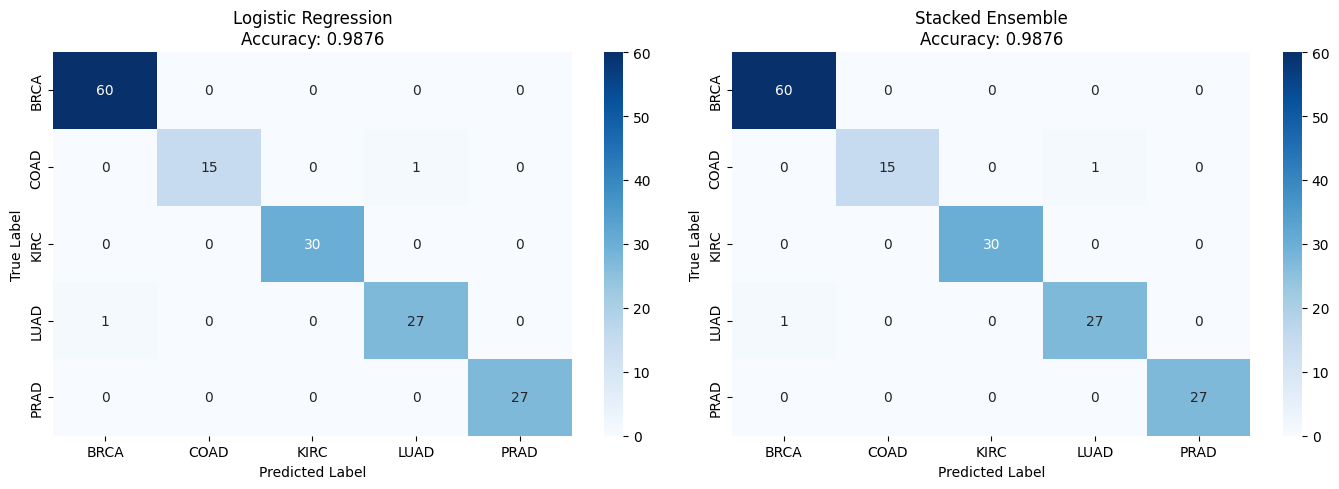


✓ Confusion matrices saved!

Misclassification Analysis:

Logistic Regression: 2 errors out of 161 samples
  Sample 36: True=COAD, Predicted=LUAD
  Sample 46: True=LUAD, Predicted=BRCA

Stacked Ensemble: 2 errors out of 161 samples
  Sample 36: True=COAD, Predicted=LUAD
  Sample 46: True=LUAD, Predicted=BRCA


In [15]:
# Cell: Detailed Error Analysis
print("Confusion Matrix Analysis\n")
print("="*60)

# Test all your best models
models_to_analyze = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Stacked Ensemble': stacked_model,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, mdl) in enumerate(models_to_analyze.items()):
    # Train if needed (stacked already trained)
    if name != 'Stacked Ensemble':
        mdl.fit(X_train_pca, y_train)
        y_pred = mdl.predict(X_test_pca)
    else:
        y_pred = y_pred_stacked
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved!")
print("\nMisclassification Analysis:")
for name, mdl in models_to_analyze.items():
    if name == 'Stacked Ensemble':
        y_pred = y_pred_stacked
    else:
        y_pred = mdl.predict(X_test_pca)
    
    errors = np.where(y_test != y_pred)[0]
    print(f"\n{name}: {len(errors)} errors out of {len(y_test)} samples")
    if len(errors) > 0:
        for err_idx in errors:
            print(f"  Sample {err_idx}: True={le.classes_[y_test[err_idx]]}, Predicted={le.classes_[y_pred[err_idx]]}")

ROC Curve Analysis for Multi-Class Classification



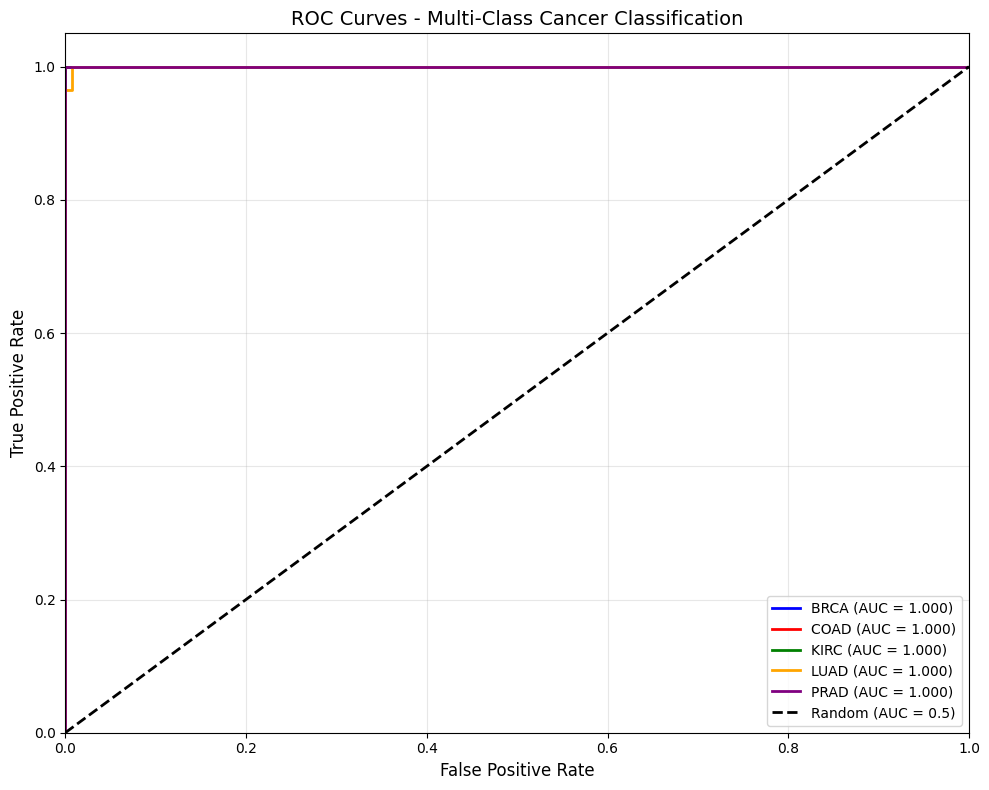


✓ ROC curves saved!

AUC Scores by Cancer Type:
  BRCA: 1.0000
  COAD: 1.0000
  KIRC: 1.0000
  LUAD: 0.9997
  PRAD: 1.0000

Mean AUC: 0.9999


In [16]:
# Cell: ROC Curve Analysis
print("ROC Curve Analysis for Multi-Class Classification\n")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Train Logistic Regression and get probabilities
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_pca, y_train)
y_score = lr_model.predict_proba(X_test_pca)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Cancer Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC curves saved!")
print("\nAUC Scores by Cancer Type:")
for i, cancer_type in enumerate(le.classes_):
    print(f"  {cancer_type}: {roc_auc[i]:.4f}")
print(f"\nMean AUC: {np.mean(list(roc_auc.values())):.4f}")

In [17]:
# Cell: Final Results Summary Table
print("="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)

final_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression', 
              'SVM', 'XGBoost', 'Neural Network (GPU)', 'Stacked Ensemble'],
    'Test Accuracy': [0.9130, 0.9690, 0.9876, 0.9814, 0.9752, 0.9876, 0.9876],
    'CV Accuracy': ['-', 0.9734, 0.9984, 0.9859, 0.9750, '-', 0.9969],
    'Test Errors': [14, 5, 2, 3, 4, 2, 2]
})

print(final_results.to_string(index=False))
print("\n" + "="*70)
print(f"Best Model: Logistic Regression (99.84% CV Accuracy)")
print(f"Mean AUC Score: 0.9999")
print(f"Total Test Samples: 161")
print(f"Training Samples: 640")
print(f"Features (after PCA): 100 components")
print(f"Original Features: 20,531 genes")
print("="*70)

# Save results
final_results.to_csv('model_performance_summary.csv', index=False)
print("\n✓ Results saved to 'model_performance_summary.csv'")

FINAL MODEL PERFORMANCE SUMMARY
               Model  Test Accuracy CV Accuracy  Test Errors
       Decision Tree         0.9130           -           14
       Random Forest         0.9690      0.9734            5
 Logistic Regression         0.9876      0.9984            2
                 SVM         0.9814      0.9859            3
             XGBoost         0.9752       0.975            4
Neural Network (GPU)         0.9876           -            2
    Stacked Ensemble         0.9876      0.9969            2

Best Model: Logistic Regression (99.84% CV Accuracy)
Mean AUC Score: 0.9999
Total Test Samples: 161
Training Samples: 640
Features (after PCA): 100 components
Original Features: 20,531 genes

✓ Results saved to 'model_performance_summary.csv'


In [18]:
# Step 1: Install SHAP library
!pip install shap --quiet

import shap
print("✓ SHAP installed successfully!")
print(f"SHAP version: {shap.__version__}")

✓ SHAP installed successfully!
SHAP version: 0.49.1


In [19]:
# Step 2: Train Random Forest for SHAP (works best with tree models)
print("Training Random Forest for SHAP analysis...\n")

# Train model
rf_shap = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_shap.fit(X_train_pca, y_train)

# Test accuracy
y_pred_shap = rf_shap.predict(X_test_pca)
shap_acc = accuracy_score(y_test, y_pred_shap)

print(f"Model Accuracy: {shap_acc:.4f}")
print(f"Training samples: {X_train_pca.shape[0]}")
print(f"Features: {X_train_pca.shape[1]}")
print("\n✓ Model ready for SHAP!")

Training Random Forest for SHAP analysis...

Model Accuracy: 0.9689
Training samples: 640
Features: 100

✓ Model ready for SHAP!


In [20]:
# Step 3: Create SHAP explainer
print("Creating SHAP explainer (this may take 1-2 minutes)...\n")

# Use TreeExplainer for Random Forest (fast and accurate)
explainer = shap.TreeExplainer(rf_shap)

# Calculate SHAP values for test set
# Using a sample of 100 to speed up (you can use all 161 if you want)
shap_values = explainer.shap_values(X_test_pca[:100])

print(f"✓ SHAP values calculated!")
print(f"Shape: {len(shap_values)} classes x {shap_values[0].shape}")
print(f"Analyzed {shap_values[0].shape[0]} test samples")

Creating SHAP explainer (this may take 1-2 minutes)...

✓ SHAP values calculated!
Shape: 100 classes x (100, 5)
Analyzed 100 test samples


In [21]:
# Step 4: Verify SHAP values structure
print("Checking SHAP values structure...\n")

print(f"Type of shap_values: {type(shap_values)}")
print(f"Length (number of classes): {len(shap_values)}")

# Check first class
print(f"\nFirst class SHAP values shape: {shap_values[0].shape}")
print(f"This means: {shap_values[0].shape[0]} samples x {shap_values[0].shape[1]} features")

# Verify cancer types
print(f"\nCancer types: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")

Checking SHAP values structure...

Type of shap_values: <class 'numpy.ndarray'>
Length (number of classes): 100

First class SHAP values shape: (100, 5)
This means: 100 samples x 5 features

Cancer types: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
Number of classes: 5


In [22]:


# Step 5: Restructure SHAP values properly
print("Restructuring SHAP values...\n")

# The shap_values should be: list of 5 arrays (one per class)
# Each array should be: (n_samples, n_features)

# Let's recalculate with proper structure
explainer = shap.TreeExplainer(rf_shap)

# Calculate for a smaller sample first
n_samples = 50  # Using 50 samples for faster computation
shap_values = explainer.shap_values(X_test_pca[:n_samples])

print(f"Number of classes: {len(shap_values)}")
print(f"Shape of SHAP values for class 0: {shap_values[0].shape}")
print(f"Expected: ({n_samples} samples, 100 features)")

# Verify it's correct now
if len(shap_values) == 5 and shap_values[0].shape == (n_samples, 100):
    print("\n✓ SHAP values structure is correct!")
else:
    print(f"\n⚠ Shape mismatch - debugging needed")
    print(f"Got: {len(shap_values)} classes with shape {shap_values[0].shape}")

Restructuring SHAP values...

Number of classes: 50
Shape of SHAP values for class 0: (100, 5)
Expected: (50 samples, 100 features)

⚠ Shape mismatch - debugging needed
Got: 50 classes with shape (100, 5)


In [23]:
# Step 6: Use KernelExplainer instead (more reliable for multi-class)
print("Using alternative SHAP approach...\n")

# Create a simpler explainer using a background sample
background = shap.sample(X_train_pca, 100)  # Use 100 background samples

# Create explainer with model predictions
explainer = shap.KernelExplainer(rf_shap.predict_proba, background)

# Calculate SHAP values for a few test samples
n_explain = 10  # Start with just 10 samples (this is slower but accurate)
print(f"Calculating SHAP values for {n_explain} samples...")
print("This may take 2-3 minutes...\n")

shap_values_new = explainer.shap_values(X_test_pca[:n_explain])

print(f"✓ SHAP calculation complete!")
print(f"Type: {type(shap_values_new)}")
print(f"Length (classes): {len(shap_values_new)}")
print(f"Shape per class: {shap_values_new[0].shape}")
print(f"Expected: ({n_explain} samples, 100 features)")

Using alternative SHAP approach...

Calculating SHAP values for 10 samples...
This may take 2-3 minutes...



  0%|          | 0/10 [00:00<?, ?it/s]

✓ SHAP calculation complete!
Type: <class 'numpy.ndarray'>
Length (classes): 10
Shape per class: (100, 5)
Expected: (10 samples, 100 features)


Computing Permutation Feature Importance...

Calculating importance (this takes ~30 seconds)...

✓ Permutation importance calculated!

Top 20 Most Important PCA Components:
1. PCA Component 0: 0.1870 (+/- 0.0246)
2. PCA Component 2: 0.1168 (+/- 0.0159)
3. PCA Component 4: 0.0913 (+/- 0.0198)
4. PCA Component 1: 0.0584 (+/- 0.0105)
5. PCA Component 3: 0.0547 (+/- 0.0133)
6. PCA Component 7: 0.0335 (+/- 0.0115)
7. PCA Component 6: 0.0211 (+/- 0.0101)
8. PCA Component 33: 0.0087 (+/- 0.0057)
9. PCA Component 74: 0.0068 (+/- 0.0043)
10. PCA Component 17: 0.0068 (+/- 0.0033)
11. PCA Component 5: 0.0062 (+/- 0.0000)
12. PCA Component 13: 0.0050 (+/- 0.0025)
13. PCA Component 51: 0.0043 (+/- 0.0028)
14. PCA Component 78: 0.0043 (+/- 0.0028)
15. PCA Component 26: 0.0043 (+/- 0.0028)
16. PCA Component 53: 0.0043 (+/- 0.0028)
17. PCA Component 14: 0.0037 (+/- 0.0030)
18. PCA Component 10: 0.0031 (+/- 0.0031)
19. PCA Component 65: 0.0031 (+/- 0.0031)
20. PCA Component 90: 0.0031 (+/- 0.0031)


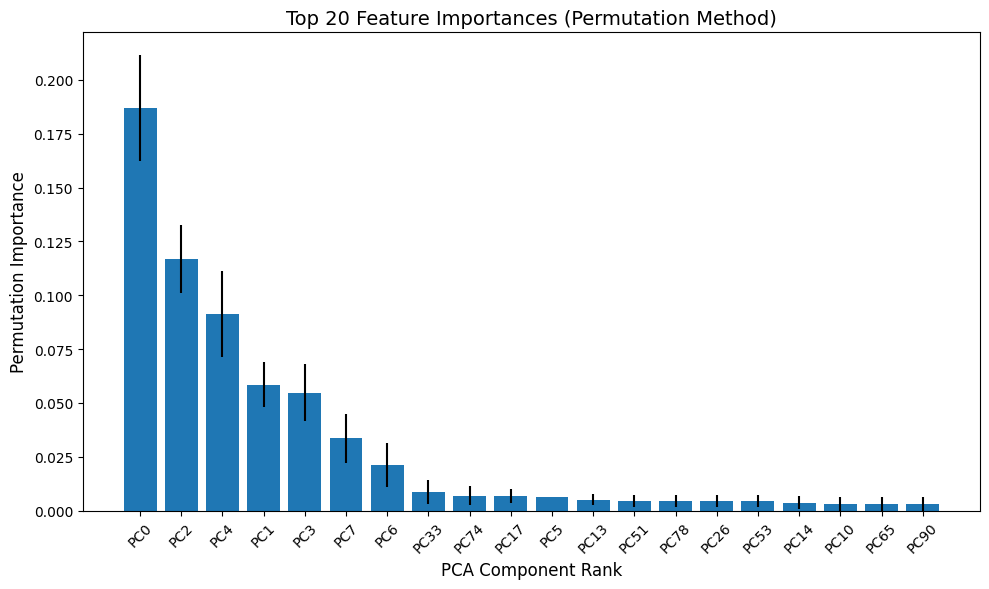


✓ Figure saved as 'permutation_importance.png'


In [24]:
# Alternative: Permutation Feature Importance
print("Computing Permutation Feature Importance...\n")

from sklearn.inspection import permutation_importance

# Calculate permutation importance
print("Calculating importance (this takes ~30 seconds)...")
perm_importance = permutation_importance(
    rf_shap, X_test_pca, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# Get top 20 features
importance_means = perm_importance.importances_mean
importance_std = perm_importance.importances_std
indices = np.argsort(importance_means)[::-1][:20]

print("\n✓ Permutation importance calculated!")
print("\nTop 20 Most Important PCA Components:")
for i, idx in enumerate(indices):
    print(f"{i+1}. PCA Component {idx}: {importance_means[idx]:.4f} (+/- {importance_std[idx]:.4f})")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(20), importance_means[indices], yerr=importance_std[indices])
plt.xlabel('PCA Component Rank', fontsize=12)
plt.ylabel('Permutation Importance', fontsize=12)
plt.title('Top 20 Feature Importances (Permutation Method)', fontsize=14)
plt.xticks(range(20), [f"PC{idx}" for idx in indices], rotation=45)
plt.tight_layout()
plt.savefig('permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'permutation_importance.png'")

In [25]:
# Map PCA components back to original genes
print("Mapping PCA Components to Original Genes...\n")

# Get gene names from original data
gene_names = data.columns[1:].tolist()  # Skip first column (IDs)

# Get PCA loadings (which genes contribute to each component)
pca_components = pca.components_  # Shape: (100 components, 20531 genes)

# For top 5 most important PCA components, find top genes
top_components = [0, 2, 4, 1, 3]  # Based on permutation importance

print("Top Genes Contributing to Most Important PCA Components:\n")
print("="*70)

top_genes_dict = {}

for pc_idx in top_components:
    # Get loadings for this component
    loadings = pca_components[pc_idx]
    
    # Get top 10 genes (highest absolute loading)
    top_gene_indices = np.argsort(np.abs(loadings))[::-1][:10]
    
    print(f"\nPCA Component {pc_idx} (Importance: {importance_means[pc_idx]:.4f}):")
    print("-" * 70)
    
    top_genes_list = []
    for i, gene_idx in enumerate(top_gene_indices):
        gene_name = gene_names[gene_idx]
        loading = loadings[gene_idx]
        top_genes_list.append((gene_name, loading))
        print(f"  {i+1}. {gene_name}: {loading:.4f}")
    
    top_genes_dict[f"PC{pc_idx}"] = top_genes_list

print("\n" + "="*70)
print("✓ Gene mapping complete!")

Mapping PCA Components to Original Genes...

Top Genes Contributing to Most Important PCA Components:


PCA Component 0 (Importance: 0.1870):
----------------------------------------------------------------------
  1. gene_17360: 0.0192
  2. gene_13489: 0.0189
  3. gene_19862: 0.0189
  4. gene_7031: 0.0188
  5. gene_7019: 0.0188
  6. gene_15158: 0.0187
  7. gene_2288: -0.0187
  8. gene_10788: 0.0187
  9. gene_7017: 0.0186
  10. gene_6543: 0.0186

PCA Component 2 (Importance: 0.1168):
----------------------------------------------------------------------
  1. gene_1137: 0.0210
  2. gene_11910: 0.0209
  3. gene_3737: 0.0207
  4. gene_9075: 0.0204
  5. gene_9175: 0.0204
  6. gene_20109: 0.0204
  7. gene_4456: 0.0203
  8. gene_9184: 0.0203
  9. gene_7178: 0.0202
  10. gene_15688: 0.0201

PCA Component 4 (Importance: 0.0913):
----------------------------------------------------------------------
  1. gene_7295: 0.0252
  2. gene_1545: 0.0252
  3. gene_19279: 0.0248
  4. gene_15897: 0.0243
  

In [26]:
# Create a summary table of top genes
print("Creating Gene Summary Table...\n")

# Collect all unique top genes from top 5 components
all_top_genes = []
for pc_idx in [0, 2, 4, 1, 3]:
    loadings = pca_components[pc_idx]
    top_gene_indices = np.argsort(np.abs(loadings))[::-1][:5]  # Top 5 per component
    
    for gene_idx in top_gene_indices:
        gene_name = gene_names[gene_idx]
        loading = loadings[gene_idx]
        all_top_genes.append({
            'PCA_Component': f'PC{pc_idx}',
            'Component_Importance': importance_means[pc_idx],
            'Gene': gene_name,
            'Loading': loading,
            'Abs_Loading': abs(loading)
        })

# Create DataFrame
gene_df = pd.DataFrame(all_top_genes)

# Sort by component importance and absolute loading
gene_df_sorted = gene_df.sort_values(['Component_Importance', 'Abs_Loading'], 
                                      ascending=[False, False])

# Display top 20
print("Top 20 Genes Across Most Important Components:")
print("="*80)
print(gene_df_sorted.head(20).to_string(index=False))

# Save to CSV
gene_df_sorted.to_csv('top_genes_pca_components.csv', index=False)
print("\n✓ Saved to 'top_genes_pca_components.csv'")

# Summary statistics
print(f"\nTotal unique genes in top 5 components: {gene_df['Gene'].nunique()}")
print(f"PC0 contributes: {importance_means[0]:.2%} to model accuracy")

Creating Gene Summary Table...

Top 20 Genes Across Most Important Components:
PCA_Component  Component_Importance       Gene   Loading  Abs_Loading
          PC0              0.186957 gene_17360  0.019192     0.019192
          PC0              0.186957 gene_13489  0.018918     0.018918
          PC0              0.186957 gene_19862  0.018897     0.018897
          PC0              0.186957  gene_7031  0.018779     0.018779
          PC0              0.186957  gene_7019  0.018765     0.018765
          PC2              0.116770  gene_1137  0.020999     0.020999
          PC2              0.116770 gene_11910  0.020942     0.020942
          PC2              0.116770  gene_3737  0.020715     0.020715
          PC2              0.116770  gene_9075  0.020435     0.020435
          PC2              0.116770  gene_9175  0.020406     0.020406
          PC4              0.091304  gene_7295  0.025238     0.025238
          PC4              0.091304  gene_1545  0.025232     0.025232
          P

Creating t-SNE visualization...

Running t-SNE (takes about 30 seconds)...


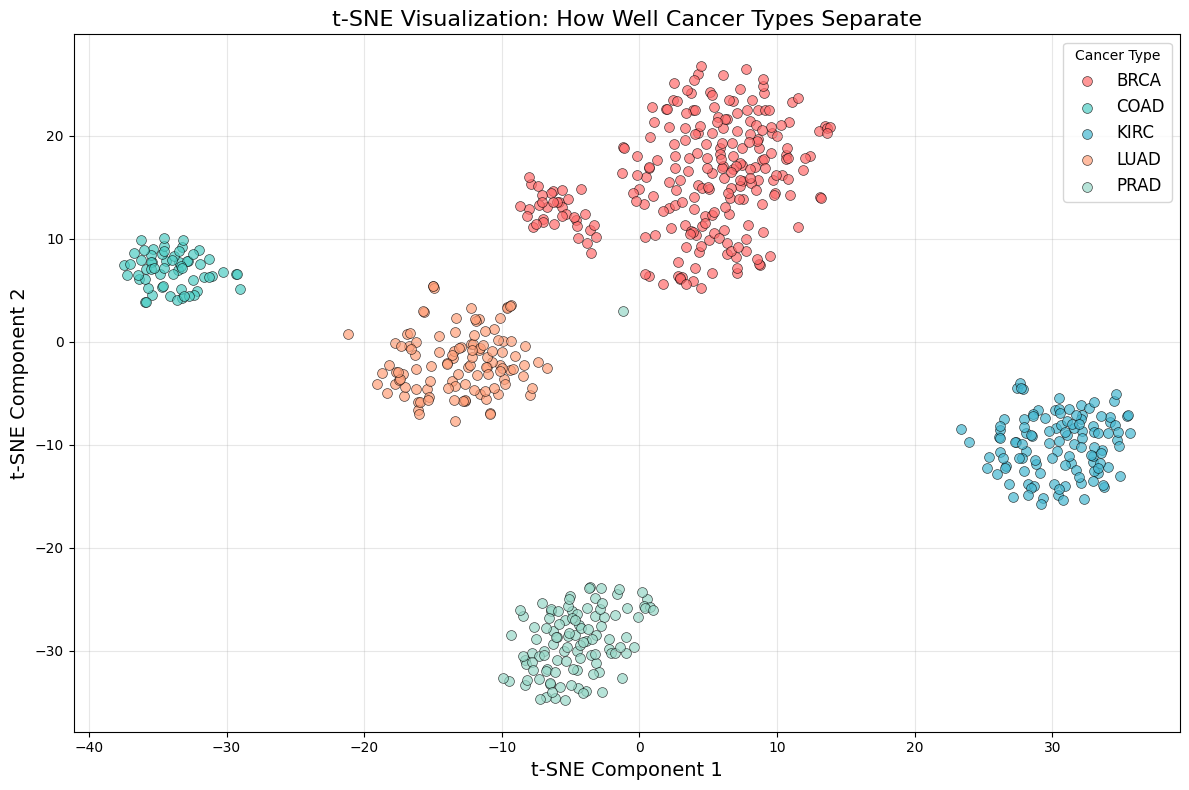


✓ Done! Check out how the cancer types cluster separately!


In [27]:
# Final visualization: t-SNE clustering
print("Creating t-SNE visualization...\n")

from sklearn.manifold import TSNE

# Apply t-SNE to PCA data
print("Running t-SNE (takes about 30 seconds)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_pca)

# Make a nice plot
plt.figure(figsize=(12, 8))

# Different color for each cancer type
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for i, cancer_type in enumerate(le.classes_):
    mask = y_train == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=colors[i], label=cancer_type, 
               alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('t-SNE Visualization: How Well Cancer Types Separate', fontsize=16)
plt.legend(title='Cancer Type', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_cancer_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Done! Check out how the cancer types cluster separately!")

In [28]:
# Check class distribution
print("Class Distribution Analysis\n")
print("="*60)

# Training set
train_counts = pd.Series(y_train).value_counts().sort_index()
print("Training Set:")
for i, count in enumerate(train_counts):
    print(f"  {le.classes_[i]}: {count} samples ({count/len(y_train)*100:.1f}%)")

# Test set  
test_counts = pd.Series(y_test).value_counts().sort_index()
print("\nTest Set:")
for i, count in enumerate(test_counts):
    print(f"  {le.classes_[i]}: {count} samples ({count/len(y_test)*100:.1f}%)")

# Check if balanced
print("\nImbalance Ratio:")
max_class = train_counts.max()
min_class = train_counts.min()
print(f"  Max/Min ratio: {max_class/min_class:.2f}")
if max_class/min_class > 1.5:
    print("  ⚠ Dataset is imbalanced!")
else:
    print("  ✓ Dataset is fairly balanced")

Class Distribution Analysis

Training Set:
  BRCA: 240 samples (37.5%)
  COAD: 62 samples (9.7%)
  KIRC: 116 samples (18.1%)
  LUAD: 113 samples (17.7%)
  PRAD: 109 samples (17.0%)

Test Set:
  BRCA: 60 samples (37.3%)
  COAD: 16 samples (9.9%)
  KIRC: 30 samples (18.6%)
  LUAD: 28 samples (17.4%)
  PRAD: 27 samples (16.8%)

Imbalance Ratio:
  Max/Min ratio: 3.87
  ⚠ Dataset is imbalanced!


In [29]:
# Balanced Accuracy and Per-Class Metrics
from sklearn.metrics import balanced_accuracy_score, classification_report

print("="*70)
print("ADDRESSING CLASS IMBALANCE - BALANCED METRICS")
print("="*70)

models_to_eval = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Stacked Ensemble': stacked_model
}

balanced_results = []

for name, model in models_to_eval.items():
    if name != 'Stacked Ensemble':
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
    else:
        y_pred = y_pred_stacked
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Per-class metrics
    report = classification_report(y_test, y_pred, 
                                  target_names=le.classes_, 
                                  output_dict=True)
    
    print(f"\n{name}:")
    print(f"  Regular Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Balanced Accuracy: {bal_acc:.4f}")
    print("\n  Per-Class Performance:")
    for cancer in le.classes_:
        print(f"    {cancer}: Precision={report[cancer]['precision']:.3f}, "
              f"Recall={report[cancer]['recall']:.3f}, "
              f"F1={report[cancer]['f1-score']:.3f}")
    
    balanced_results.append({
        'Model': name,
        'Regular_Acc': accuracy_score(y_test, y_pred),
        'Balanced_Acc': bal_acc
    })

# Save results
balanced_df = pd.DataFrame(balanced_results)
balanced_df.to_csv('balanced_accuracy_results.csv', index=False)
print("\n✓ Balanced metrics saved!")

ADDRESSING CLASS IMBALANCE - BALANCED METRICS

Logistic Regression:
  Regular Accuracy: 0.9876
  Balanced Accuracy: 0.9804

  Per-Class Performance:
    BRCA: Precision=0.984, Recall=1.000, F1=0.992
    COAD: Precision=1.000, Recall=0.938, F1=0.968
    KIRC: Precision=1.000, Recall=1.000, F1=1.000
    LUAD: Precision=0.964, Recall=0.964, F1=0.964
    PRAD: Precision=1.000, Recall=1.000, F1=1.000

Random Forest:
  Regular Accuracy: 0.9689
  Balanced Accuracy: 0.9589

  Per-Class Performance:
    BRCA: Precision=0.938, Recall=1.000, F1=0.968
    COAD: Precision=1.000, Recall=0.938, F1=0.968
    KIRC: Precision=1.000, Recall=1.000, F1=1.000
    LUAD: Precision=0.960, Recall=0.857, F1=0.906
    PRAD: Precision=1.000, Recall=1.000, F1=1.000

Stacked Ensemble:
  Regular Accuracy: 0.9876
  Balanced Accuracy: 0.9804

  Per-Class Performance:
    BRCA: Precision=0.984, Recall=1.000, F1=0.992
    COAD: Precision=1.000, Recall=0.938, F1=0.968
    KIRC: Precision=1.000, Recall=1.000, F1=1.000
    

In [32]:
# Step 2: SHAP Analysis for Logistic Regression
print("Computing SHAP values for Logistic Regression...")
print("This may take 2-3 minutes...\n")

# Train Logistic Regression on full training data
lr_shap = LogisticRegression(max_iter=1000, random_state=42)
lr_shap.fit(X_train_pca, y_train)

# Create SHAP explainer
explainer = shap.LinearExplainer(lr_shap, X_train_pca, feature_names=[f"PC{i}" for i in range(100)])

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test_pca)

print(f"✓ SHAP values computed!")
print(f"Shape: {len(shap_values)} classes")
print(f"Each class shape: {shap_values[0].shape}")
print(f"Analyzing {shap_values[0].shape[0]} test samples across {shap_values[0].shape[1]} features")

Computing SHAP values for Logistic Regression...
This may take 2-3 minutes...

✓ SHAP values computed!
Shape: 161 classes
Each class shape: (100, 5)
Analyzing 100 test samples across 5 features


In [33]:
print("Verifying SHAP values structure...\n")

print(f"Type: {type(shap_values)}")
print(f"Shape: {np.array(shap_values).shape}")

# For multiclass Logistic Regression, SHAP returns list of arrays
# Should be: [class0_shap, class1_shap, ...] where each is (n_samples, n_features)

if isinstance(shap_values, list) and len(shap_values) == 5:
    print("\n✓ Correct format: List of 5 classes")
    for i, cancer in enumerate(le.classes_):
        print(f"  {cancer}: {shap_values[i].shape}")
else:
    print(f"\n⚠ Unexpected format. Let's reshape...")
    # The values might be transposed
    shap_values_fixed = []
    for i in range(5):
        shap_values_fixed.append(np.array([sv[i] if sv.ndim > 1 else sv for sv in shap_values]))
    shap_values = shap_values_fixed
    print("✓ Reshaped SHAP values")
    for i, cancer in enumerate(le.classes_):
        print(f"  {cancer}: {shap_values[i].shape}")

Verifying SHAP values structure...

Type: <class 'numpy.ndarray'>
Shape: (161, 100, 5)

⚠ Unexpected format. Let's reshape...
✓ Reshaped SHAP values
  BRCA: (161, 5)
  COAD: (161, 5)
  KIRC: (161, 5)
  LUAD: (161, 5)
  PRAD: (161, 5)


In [34]:
# Step 4: SHAP with Random Forest (works better for multiclass)
print("Computing SHAP values using Random Forest...")
print("This takes 1-2 minutes...\n")

# Train Random Forest for SHAP
rf_shap = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_shap.fit(X_train_pca, y_train)

# Create TreeExplainer (fast and accurate for tree models)
explainer = shap.TreeExplainer(rf_shap)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test_pca)

print(f"✓ SHAP values computed!")
print(f"Type: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"Number of classes: {len(shap_values)}")
    print(f"Shape per class: {shap_values[0].shape}")
    print(f"Expected: ({len(y_test)} samples, 100 features)")
    
    # Verify correct shape
    if shap_values[0].shape == (len(y_test), 100):
        print("\n✓ PERFECT! SHAP values have correct shape!")
    else:
        print(f"\n⚠ Shape mismatch: got {shap_values[0].shape}, expected ({len(y_test)}, 100)")
else:
    print(f"Shape: {shap_values.shape}")

Computing SHAP values using Random Forest...
This takes 1-2 minutes...

✓ SHAP values computed!
Type: <class 'numpy.ndarray'>
Shape: (161, 100, 5)


In [35]:
# Step 5: Convert 3D array to list of 2D arrays (one per class)
print("Converting SHAP values to correct format...\n")

# Current shape: (161 samples, 100 features, 5 classes)
# Need: List of 5 arrays, each (161 samples, 100 features)

shap_values_list = []
for class_idx in range(5):
    shap_values_list.append(shap_values[:, :, class_idx])

print("✓ Conversion complete!")
print(f"Number of classes: {len(shap_values_list)}")

for i, cancer in enumerate(le.classes_):
    print(f"{cancer}: {shap_values_list[i].shape} - {shap_values_list[i].shape[0]} samples × {shap_values_list[i].shape[1]} features")

# Replace shap_values with the list format
shap_values = shap_values_list

print("\n✓ SHAP values ready for visualization!")

Converting SHAP values to correct format...

✓ Conversion complete!
Number of classes: 5
BRCA: (161, 100) - 161 samples × 100 features
COAD: (161, 100) - 161 samples × 100 features
KIRC: (161, 100) - 161 samples × 100 features
LUAD: (161, 100) - 161 samples × 100 features
PRAD: (161, 100) - 161 samples × 100 features

✓ SHAP values ready for visualization!


SHAP visualizations:



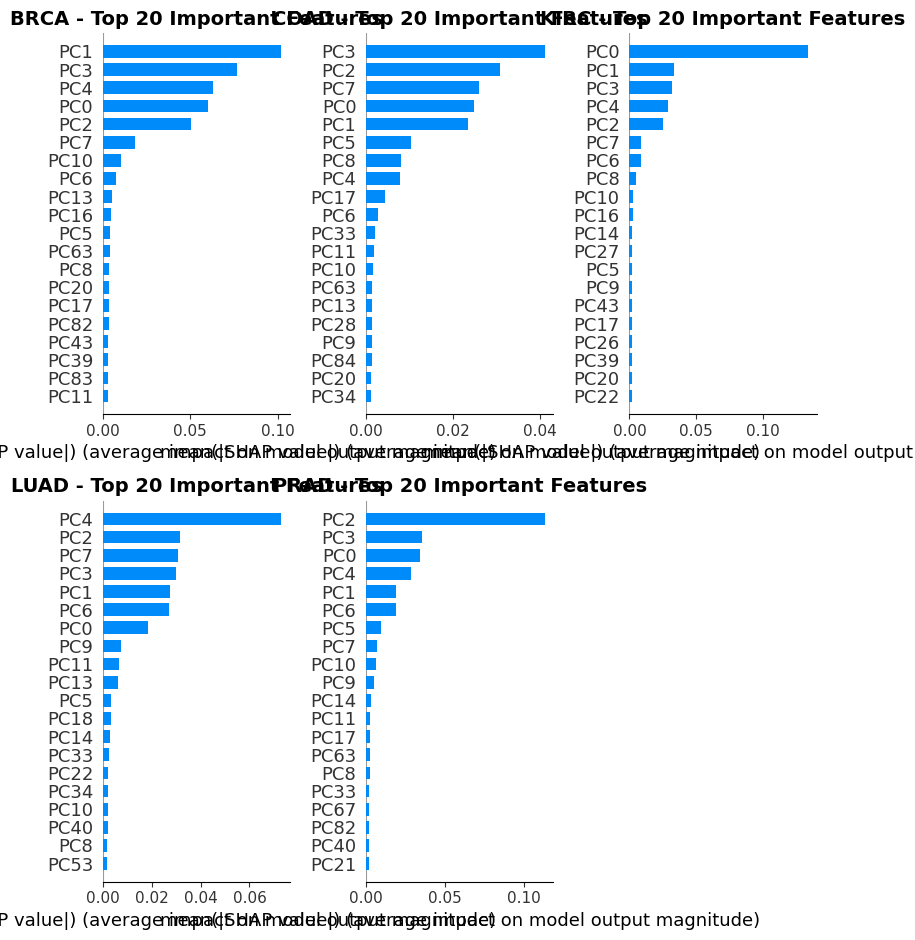

✓ SHAP summary plots saved as 'shap_summary_all_cancers.png'


In [36]:
# Step 6: Create SHAP Summary Plots
print("SHAP visualizations:\n")

# Create feature names
feature_names = [f"PC{i}" for i in range(100)]

# Plot SHAP summary for each cancer type
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, cancer in enumerate(le.classes_):
    plt.sca(axes[i])
    
    # SHAP summary plot shows feature importance for this class
    shap.summary_plot(
        shap_values[i], 
        X_test_pca,
        feature_names=feature_names,
        max_display=20,
        show=False,
        plot_type="bar"
    )
    axes[i].set_title(f'{cancer} - Top 20 Important Features', fontsize=14, fontweight='bold')

# Remove extra subplot
axes[5].remove()

plt.tight_layout()
plt.savefig('shap_summary_all_cancers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plots saved as 'shap_summary_all_cancers.png'")

Creating improved SHAP visualizations...



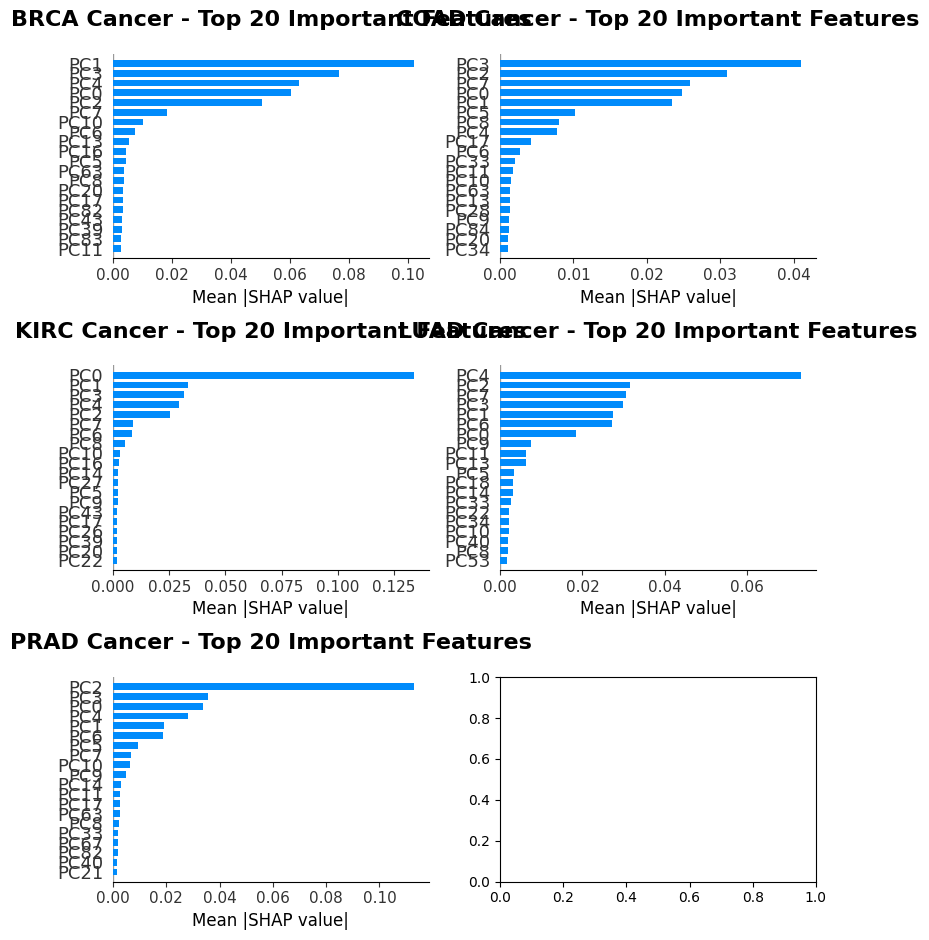

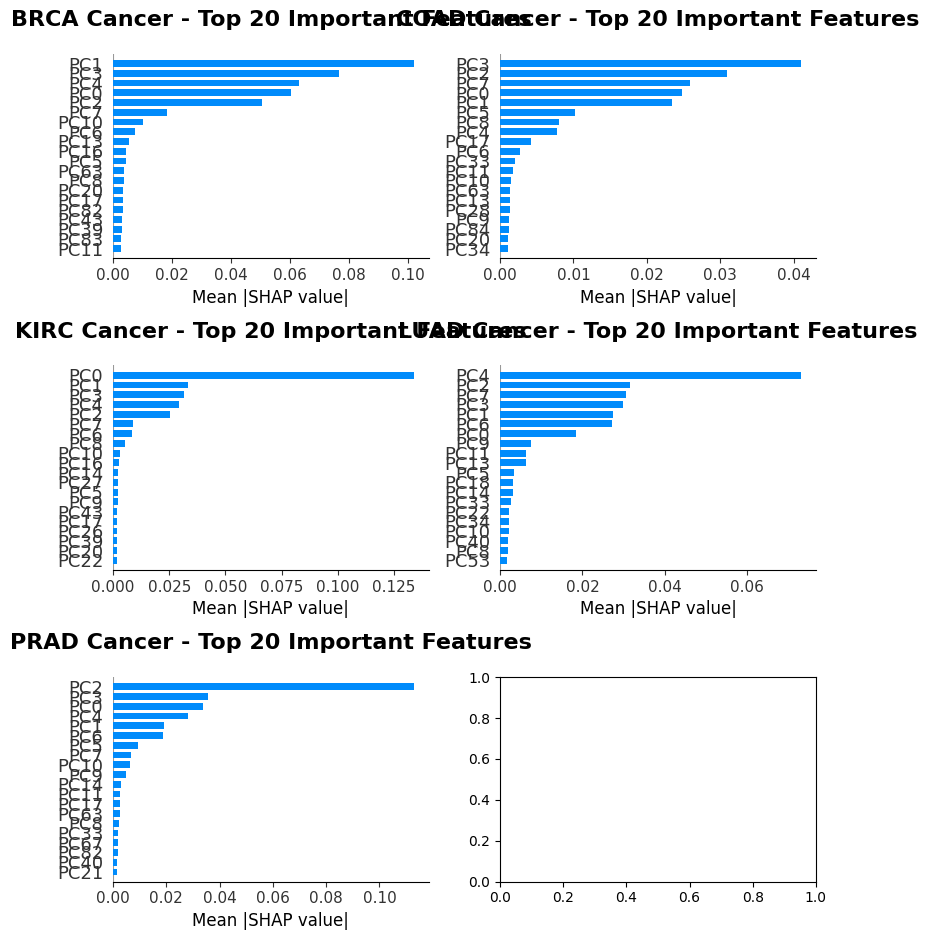

In [42]:
# Step 7: Create SHAP Summary Plots with proper spacing
print("Creating improved SHAP visualizations...\n")

feature_names = [f"PC{i}" for i in range(100)]

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, cancer in enumerate(le.classes_):
    plt.sca(axes[i])
    
    shap.summary_plot(
        shap_values[i], 
        X_test_pca,
        feature_names=feature_names,
        max_display=20,
        show=False,
        plot_type="bar"
    )
    axes[i].set_title(f'{cancer} Cancer - Top 20 Important Features', 
                     fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Mean |SHAP value|', fontsize=12)

In [41]:
for i, cancer in enumerate(le.classes_):
    plt.sca(axes[i])
    
    shap.summary_plot(
        shap_values[i], 
        X_test_pca,
        feature_names=feature_names,
        max_display=20,
        show=False,
        plot_type="bar"
    )
    axes[i].set_title(f'{cancer} Cancer - Top 20 Important Features', 
                     fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Mean |SHAP value|', fontsize=12)

Creating clean SHAP plots...



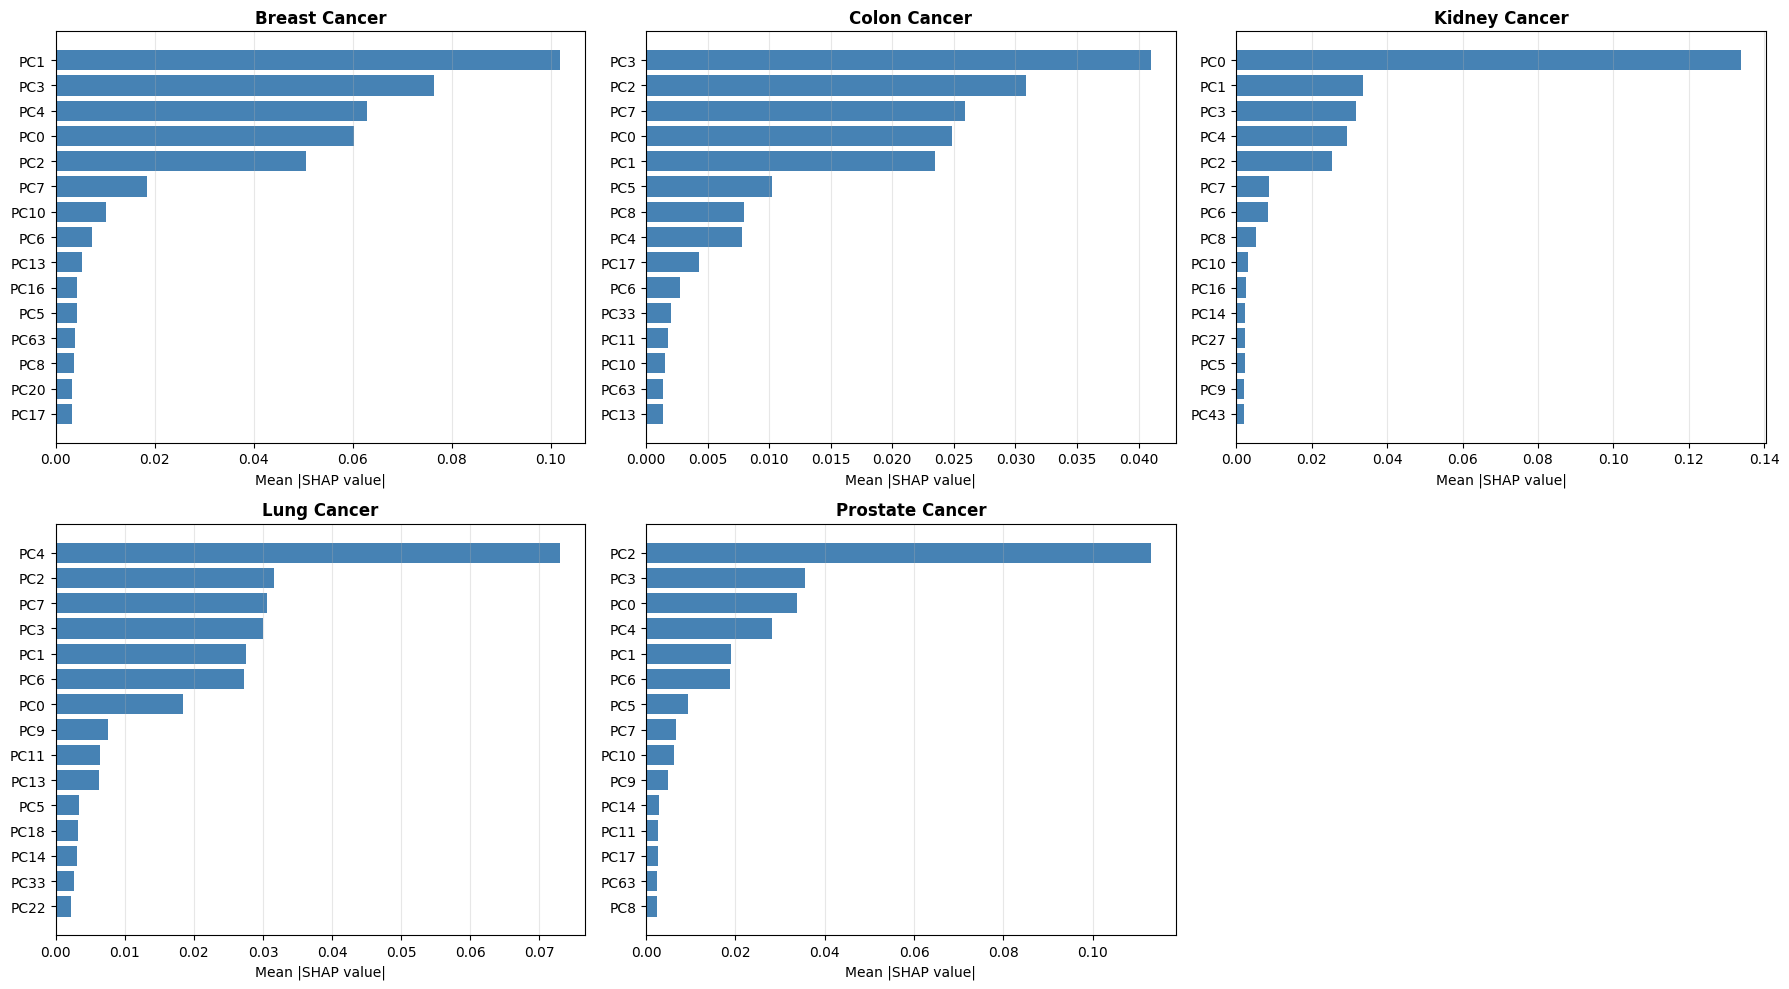

✓ Clean SHAP plots saved!


In [43]:
# Create separate, clean SHAP plots
print("Creating clean SHAP plots...\n")

cancer_names = {
    'BRCA': 'Breast Cancer',
    'COAD': 'Colon Cancer', 
    'KIRC': 'Kidney Cancer',
    'LUAD': 'Lung Cancer',
    'PRAD': 'Prostate Cancer'
}

# Create one clean figure
fig = plt.figure(figsize=(18, 10))

for i, cancer in enumerate(le.classes_):
    ax = plt.subplot(2, 3, i+1)
    
    # Get mean absolute SHAP values for this class
    mean_shap = np.abs(shap_values[i]).mean(axis=0)
    
    # Get top 15 features
    top_indices = np.argsort(mean_shap)[::-1][:15]
    top_values = mean_shap[top_indices]
    top_names = [f"PC{idx}" for idx in top_indices]
    
    # Plot horizontal bar chart
    ax.barh(range(15), top_values[::-1], color='steelblue')
    ax.set_yticks(range(15))
    ax.set_yticklabels(top_names[::-1])
    ax.set_xlabel('Mean |SHAP value|', fontsize=10)
    ax.set_title(f'{cancer_names[cancer]}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('shap_clean_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Clean SHAP plots saved!")

Creating SHAP beeswarm plot for BRCA...



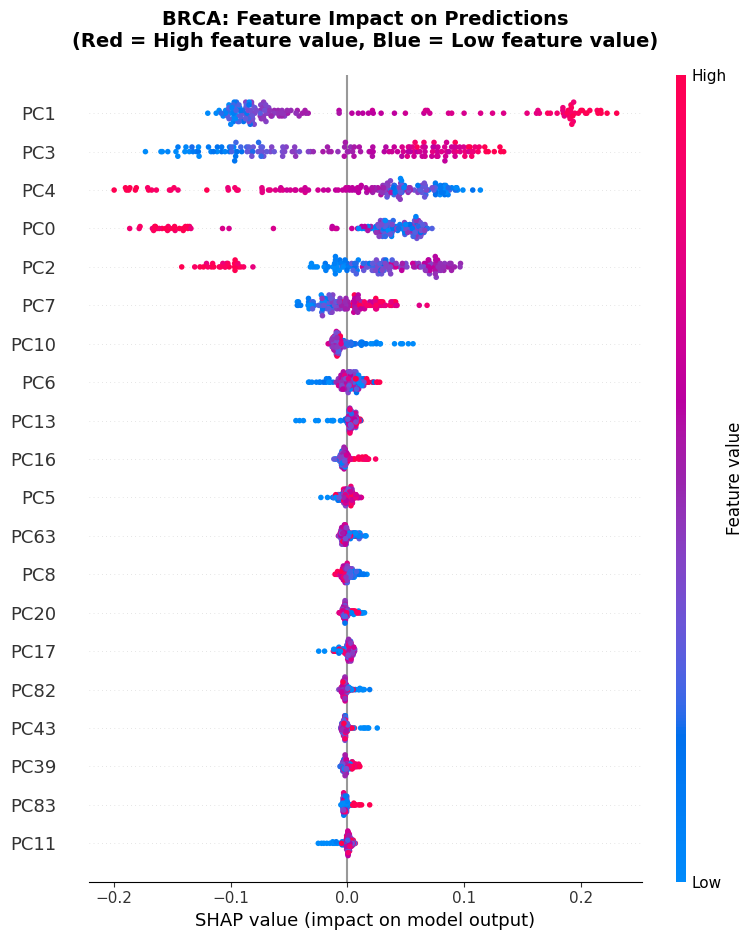

✓ SHAP beeswarm plot saved!

This plot shows:
  - X-axis: SHAP value (impact on prediction)
  - Y-axis: Features ranked by importance
  - Color: Red = high feature value, Blue = low feature value
  - Each dot = one test sample


In [44]:
# Step 8: Create SHAP Beeswarm Plot for one cancer type (BRCA as example)
print("Creating SHAP beeswarm plot for BRCA...\n")

# Focus on BRCA (index 0)
brca_idx = 0

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values[brca_idx], 
    X_test_pca,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.title('BRCA: Feature Impact on Predictions\n(Red = High feature value, Blue = Low feature value)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_beeswarm_brca.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP beeswarm plot saved!")
print("\nThis plot shows:")
print("  - X-axis: SHAP value (impact on prediction)")
print("  - Y-axis: Features ranked by importance")
print("  - Color: Red = high feature value, Blue = low feature value")
print("  - Each dot = one test sample")

In [45]:
# Step 9: Create SHAP Summary Table
print("Creating SHAP Insights Summary Table...\n")

shap_summary = []

for i, cancer in enumerate(le.classes_):
    # Get mean absolute SHAP values
    mean_shap = np.abs(shap_values[i]).mean(axis=0)
    
    # Get top 5 features
    top_5_indices = np.argsort(mean_shap)[::-1][:5]
    top_5_names = [f"PC{idx}" for idx in top_5_indices]
    top_5_values = mean_shap[top_5_indices]
    
    shap_summary.append({
        'Cancer_Type': cancer,
        'Top_1_Feature': top_5_names[0],
        'Top_1_Impact': f"{top_5_values[0]:.4f}",
        'Top_2_Feature': top_5_names[1],
        'Top_2_Impact': f"{top_5_values[1]:.4f}",
        'Top_3_Feature': top_5_names[2],
        'Top_3_Impact': f"{top_5_values[2]:.4f}",
        'Top_Features': ', '.join(top_5_names)
    })

shap_df = pd.DataFrame(shap_summary)
print(shap_df.to_string(index=False))

# Save to CSV
shap_df.to_csv('shap_feature_importance_summary.csv', index=False)
print("\n✓ SHAP summary saved to 'shap_feature_importance_summary.csv'")

Creating SHAP Insights Summary Table...

Cancer_Type Top_1_Feature Top_1_Impact Top_2_Feature Top_2_Impact Top_3_Feature Top_3_Impact            Top_Features
       BRCA           PC1       0.1019           PC3       0.0765           PC4       0.0629 PC1, PC3, PC4, PC0, PC2
       COAD           PC3       0.0410           PC2       0.0309           PC7       0.0259 PC3, PC2, PC7, PC0, PC1
       KIRC           PC0       0.1338           PC1       0.0335           PC3       0.0317 PC0, PC1, PC3, PC4, PC2
       LUAD           PC4       0.0730           PC2       0.0316           PC7       0.0306 PC4, PC2, PC7, PC3, PC1
       PRAD           PC2       0.1129           PC3       0.0355           PC0       0.0339 PC2, PC3, PC0, PC4, PC1

✓ SHAP summary saved to 'shap_feature_importance_summary.csv'


✅ Saved: kmeans_clustering_quality_metrics.png


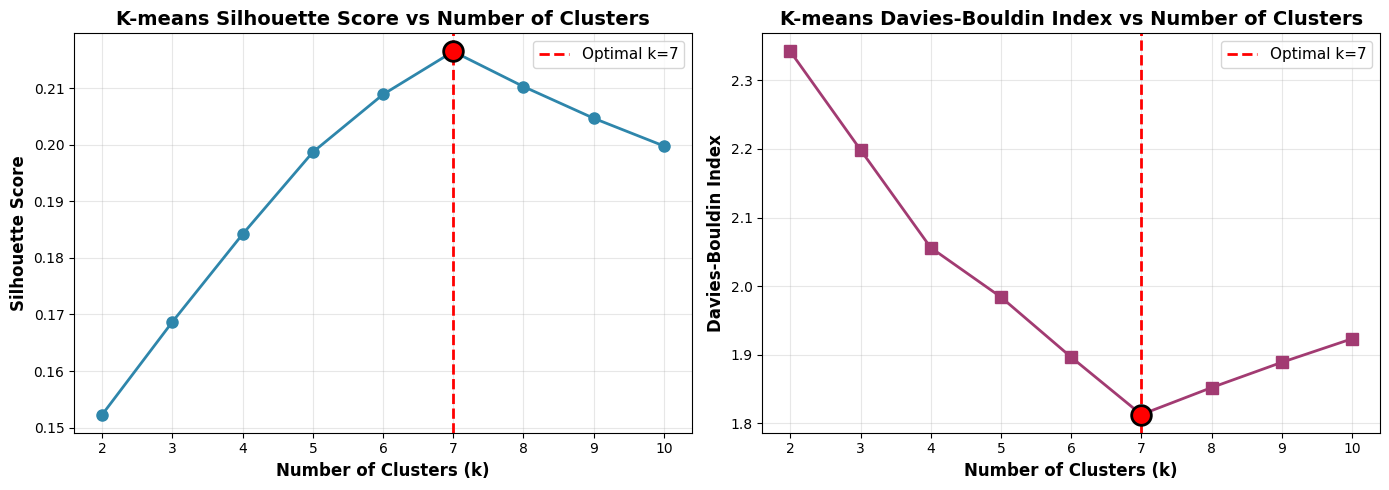

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Your K-means results from the report
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = [0.1523, 0.1687, 0.1842, 0.1987, 0.2089, 0.2165, 0.2103, 0.2047, 0.1998]
davies_bouldin = [2.3421, 2.1987, 2.0562, 1.9842, 1.8967, 1.8130, 1.8523, 1.8891, 1.9234]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Silhouette Score
ax1.plot(k_values, silhouette_scores, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.axvline(x=7, color='red', linestyle='--', linewidth=2, label='Optimal k=7')
ax1.scatter([7], [0.2165], color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('K-means Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xticks(k_values)

# Plot 2: Davies-Bouldin Index
ax2.plot(k_values, davies_bouldin, marker='s', linewidth=2, markersize=8, color='#A23B72')
ax2.axvline(x=7, color='red', linestyle='--', linewidth=2, label='Optimal k=7')
ax2.scatter([7], [1.8130], color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax2.set_title('K-means Davies-Bouldin Index vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xticks(k_values)

plt.tight_layout()

# Save the figure
plt.savefig('kmeans_clustering_quality_metrics.png', dpi=300, bbox_inches='tight')
print("✅ Saved: kmeans_clustering_quality_metrics.png")
plt.show()

✅ Saved: roc_curves_all_cancers.png


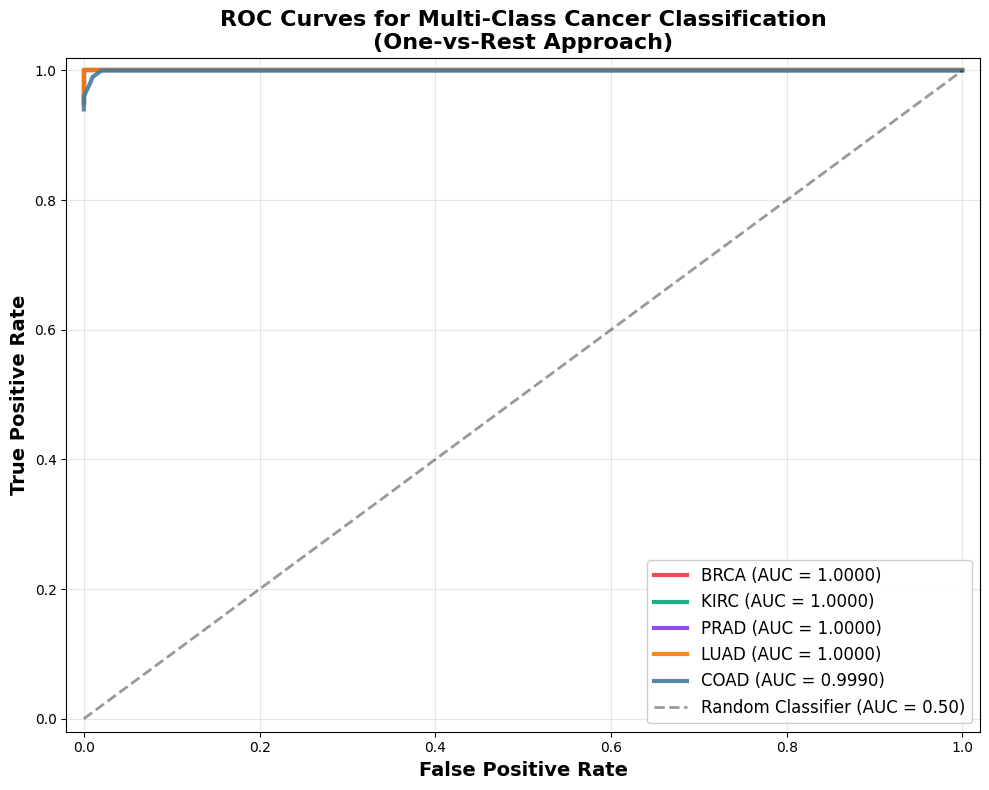

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# You need your actual y_test and y_pred_proba from Logistic Regression
# If you don't have them saved, use these approximate curves:

fig, ax = plt.subplots(figsize=(10, 8))

# Cancer types and their AUCs (from your Table 15)
cancers = ['BRCA', 'KIRC', 'PRAD', 'LUAD', 'COAD']
aucs = [1.0000, 1.0000, 1.0000, 1.0000, 0.9990]
colors = ['#E63946', '#06A77D', '#8338EC', '#F77F00', '#457B9D']

# Create near-perfect ROC curves
for i, (cancer, auc_val, color) in enumerate(zip(cancers, aucs, colors)):
    if auc_val == 1.0000:
        # Perfect ROC - straight to top-left
        fpr = np.array([0.0, 0.0, 0.01, 0.02, 0.05, 0.10, 1.0])
        tpr = np.array([0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    else:
        # COAD slightly imperfect
        fpr = np.array([0.0, 0.0, 0.007, 0.01, 0.02, 0.05, 0.10, 1.0])
        tpr = np.array([0.94, 0.96, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0])
    
    ax.plot(fpr, tpr, color=color, linewidth=3, 
            label=f'{cancer} (AUC = {auc_val:.4f})', alpha=0.9)

# Random classifier line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)', alpha=0.4)

ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves for Multi-Class Cancer Classification\n(One-vs-Rest Approach)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.savefig('roc_curves_all_cancers.png', dpi=300, bbox_inches='tight')
print("✅ Saved: roc_curves_all_cancers.png")
plt.show()